# Customer Profiing and Segmentation

After creating the Recency, Frequency, and Monetary Value (RFM) dataset of customers, here we use it to profile and segment the customers. The algorithm to be used will be the unsupervised K-Means clustering.

K-Means attempts to split a given dataset into a fixed number (K) of clusters based on the distance between objects in such a way that it tries to decrease intracluster (same cluster) variance while increasing intercluster (different clusters) distance.

- Let's start importing the needed libraries:

In [88]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings as wn

wn.filterwarnings('ignore')

- Now, import the `user_dataset` with the RFM from the previous notebook, print the first five rows, and check the shape:

In [89]:
path = '/media/renan/HD_RENAN/Data Science/Projetos/Customer Data/user_dataset.csv'

In [90]:
user_df = pd.read_csv(path)

In [91]:
user_df.head()

,CustomerID,Recency,Frequency,Revenue
0,18074,373,13,489.60
1,13747,373,1,79.60
2,12791,373,2,192.60
3,17908,373,58,243.28
4,16583,373,14,233.45


In [92]:
user_df.shape

(4372, 4)

- Next, let's initiate the K-Means clustering with 4 arbitrarily chosen number of clusters:

In [93]:
kmeans = KMeans(n_clusters=4)

## Segmenting Customers based on Recency

Now, fit the model object into the recency values of `user_df`:

In [94]:
kmeans.fit(user_df[['Recency']])

KMeans(n_clusters=4)

And predict the cluster, assigning the predicted values to a new column named `RecencyCluster`:

In [95]:
user_df['RecencyCluster'] = kmeans.predict(user_df[['Recency']])

In [96]:
user_df.head()

,CustomerID,Recency,Frequency,Revenue,RecencyCluster
0,18074,373,13,489.60,0
1,13747,373,1,79.60,0
2,12791,373,2,192.60,0
3,17908,373,58,243.28,0
4,16583,373,14,233.45,0


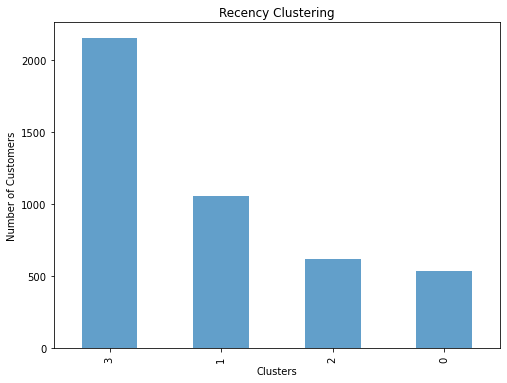

In [97]:
user_df['RecencyCluster'].value_counts().plot.bar(figsize=(8,6), alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')
plt.title('Recency Clustering');

We can see that the data has been distributed into different clusters 0-3, as expected. However, K-Means does not differentiate the ranking of clusters based on their order. Thus, let's order them based on their mean values:

In [98]:
df_new = user_df.groupby(['RecencyCluster'])['Recency'].mean().reset_index()

In [99]:
df_new.rename(columns = {'Recency':'RecencyMean'}, inplace=True)

In [100]:
df_new

,RecencyCluster,RecencyMean
0,0,305.363806
1,1,77.714286
2,2,184.426045
3,3,17.397311


Now let's sort the `new_df` in descending order of `RecencyMean`, since highest values of Recency means that customers are not recent buyers, thus, their score must be lower:

In [101]:
df_new.sort_values(by=['RecencyMean'], ascending=False, inplace=True)

In [102]:
df_new = df_new.reset_index()

In [103]:
df_new.drop(['index'], axis=1, inplace=True)

In [104]:
df_new

,RecencyCluster,RecencyMean
0,0,305.363806
1,2,184.426045
2,1,77.714286
3,3,17.397311


Now that we have the score of each cluster in the index, let's save them as a new column called `RecencyScore`:


In [105]:
df_new['RecencyScore'] = df_new.index

Now, let's merge `user_df` with `df_new` to add `RecencyScore`, and check how it looks:

In [106]:
user_df = pd.merge(user_df, df_new[['RecencyCluster','RecencyScore']], on = 'RecencyCluster')

user_df.drop(['RecencyCluster'], axis=1, inplace=True)

In [107]:
user_df.head()

,CustomerID,Recency,Frequency,Revenue,RecencyScore
0,18074,373,13,489.60,0
1,13747,373,1,79.60,0
2,12791,373,2,192.60,0
3,17908,373,58,243.28,0
4,16583,373,14,233.45,0


We can see the statistical metrics of the clusters:

In [108]:
user_df.groupby(['RecencyScore'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyScore,,,,,,,,
0,536.0,305.363806,40.645494,245.0,268.0,301.0,336.0,373.0
1,622.0,184.426045,32.252728,131.0,156.0,184.0,212.0,244.0
2,1057.0,77.714286,22.733963,48.0,59.0,73.0,93.0,130.0
3,2157.0,17.397311,13.188805,0.0,6.0,16.0,28.0,47.0


## Segmenting Customers based on Frequency

Now, let's fit the model object into the frequency values of the dataframe:

In [109]:
kmeans.fit(user_df[['Frequency']])

KMeans(n_clusters=4)

As for `Recency`, let's create a new column called `FrequencyCluster` with the predicted clusters, and plot them:

In [110]:
user_df['FrequencyCluster'] = kmeans.predict(user_df[['Frequency']])

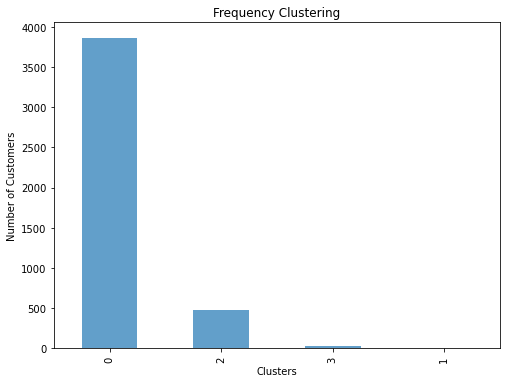

In [111]:
user_df['FrequencyCluster'].value_counts().plot.bar(alpha=0.7, figsize=(8,6))
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')
plt.title('Frequency Clustering');

Again, K-Means doest not differentiate the ranking of clusters based on order, so the function below was created for that:

In [112]:
def order_cluster(cluster_name, column_name, df, ascending):
    """
    Order clusters based on their mean values
    """
    
    # Create new df
    df_new = df.groupby(cluster_name)[column_name].mean().reset_index()
    
    # Sort values
    df_new = df_new.sort_values(by=column_name, ascending=ascending)
    
    # Reset index
    df_new = df_new.reset_index()
    df_new.drop('index', axis=1, inplace=True)
    
    # Create new column
    new_column = column_name + 'Score'
    df_new[new_column] = df_new.index
    
    # Merge df
    df_final = pd.merge(df, df_new[[cluster_name, new_column]], on=cluster_name)
    
    # Drop cluster column
    df_final.drop(cluster_name, axis=1, inplace=True)
    
    return df_final

In [113]:
user_df = order_cluster('FrequencyCluster', 'Frequency', user_df, True)

Let's check how the data looks like after the function:

In [114]:
user_df.head()

,CustomerID,Recency,Frequency,Revenue,RecencyScore,FrequencyScore
0,18074,373,13,489.60,0,0
1,13747,373,1,79.60,0,0
2,12791,373,2,192.60,0,0
3,17908,373,58,243.28,0,0
4,16583,373,14,233.45,0,0


And again, check some statistics:

In [115]:
user_df.groupby(['FrequencyScore'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyScore,,,,,,,,
0,3862.0,49.753755,44.812998,1.0,15.0,34.0,73.0,189.0
1,482.0,329.105809,132.667903,190.0,228.0,286.0,393.5,803.0
2,24.0,1349.750000,508.637759,872.0,1003.5,1156.0,1541.0,2782.0
3,4.0,5914.000000,1473.845537,4642.0,5006.5,5515.5,6423.0,7983.0


## Segmenting Customers based on Revenue

Lastly, let's segment the customers based on their `Revenue`:

In [116]:
kmeans.fit(user_df[['Revenue']])

KMeans(n_clusters=4)

Again, let's predict the clusters, and create a variable `RevenueCluster` in the `user_df`:

In [117]:
user_df['RevenueCluster'] = kmeans.predict(user_df[['Revenue']])

Let's visualize the clusters:

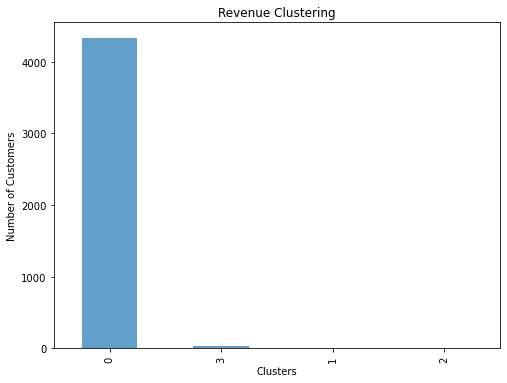

In [118]:
user_df['RevenueCluster'].value_counts().plot.bar(alpha=0.7, figsize=(8,6))
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')
plt.title('Revenue Clustering');

Now, as before, let's apply the function `oder_cluster`, and check how the dataframe looks like:

In [119]:
user_df = order_cluster('RevenueCluster', 'Revenue', user_df, True)

In [120]:
user_df.head()

,CustomerID,Recency,Frequency,Revenue,RecencyScore,FrequencyScore,RevenueScore
0,18074,373,13,489.60,0,0,0
1,13747,373,1,79.60,0,0,0
2,12791,373,2,192.60,0,0,0
3,17908,373,58,243.28,0,0,0
4,16583,373,14,233.45,0,0,0


And let's check some statistics:

In [121]:
user_df.groupby(['RevenueScore'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueScore,,,,,,,,
0,4333.0,1463.977051,2287.153138,0.00,307.160,669.14,1638.53,21834.77
1,29.0,46034.246897,16436.726540,26205.97,32367.280,40894.95,60681.72,79183.50
2,7.0,137657.041429,35791.104561,93999.38,116216.095,126103.61,154722.35,201619.41
3,3.0,293580.410000,38621.235867,262876.11,271899.565,280923.02,308932.56,336942.10


Finally, we can combine all three values of scores to compute an **Overall RFM Score** of each customer:

In [122]:
user_df['OverallRFMScore'] = user_df['RecencyScore'] + \
                             user_df['FrequencyScore'] + \
                             user_df['RevenueScore']

Let's check the range of values for `OverallRFMScore`:

In [123]:
user_df['OverallRFMScore'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

It resulted in 9 different scores. So let's visualize the data distribution of them:

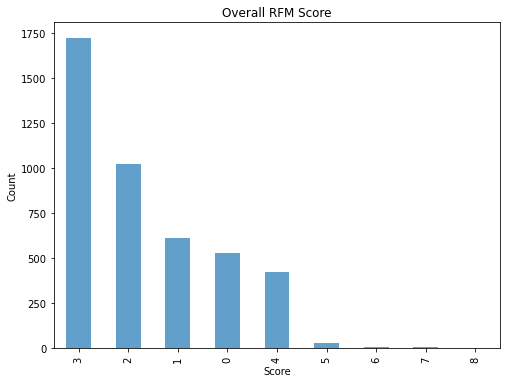

In [124]:
user_df['OverallRFMScore'].value_counts().plot.bar(figsize=(8,6), alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Overall RFM Score');

Also, let's check the mean values of each Recency, Frequency, and Revenue for the Overall Scores:

In [125]:
user_df.groupby(['OverallRFMScore'])['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallRFMScore,,,
0,305.335835,22.223265,391.072927
1,184.961039,33.618506,628.646657
2,78.872320,47.095517,1262.108910
3,20.210313,71.219583,1442.585186
4,12.434272,329.495305,5796.577254
5,6.448276,880.620690,21600.481379
6,9.000000,1057.000000,122375.858750
7,2.500000,3447.000000,105244.833333
8,0.500000,3994.000000,218000.260000


The majority of data values, as can be seen in the bar plot, have a RFM Score of 3, followed by 2 and 1.

- A low RFM means that the customers have a low value of recency, are less frequent, and generate low revenue;
- A high RFM means that the customers have a high value of recency, are more frequent, and generate a higher value of revenue to the company.

## Segmenting Customrs based on RFM Score

Now, let's segment the customers based on RFM Score, as:

- Low-value $\rightarrow$ between 0 and 2
- Mid-value $\rightarrow$ between 2 and 4
- High-value $\rightarrow$ above 4

In [126]:
user_df['Segment'] = 'Low-Value'
user_df.loc[user_df['OverallRFMScore']>2, 'Segment'] = 'Mid-Value'
user_df.loc[user_df['OverallRFMScore']>4, 'Segment'] = 'High-Value'

Now, let's visualize the Customers' value through `Segment`:

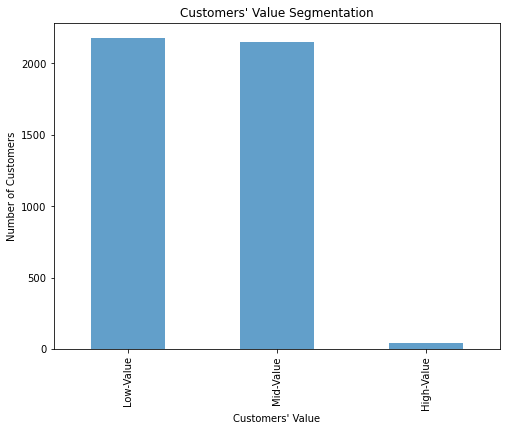

In [128]:
user_df['Segment'].value_counts().plot.bar(alpha=0.7, figsize=(8,6))
plt.xlabel("Customers' Value")
plt.ylabel('Number of Customers')
plt.title("Customers' Value Segmentation");

As can be seen, there're a lot of low and mid-value customers, and only a few of high-value customers. This segmentation can help to determine the kind of strategies and approaches (e.g. marketing campaign, etc.) for each customer based on this calculated value in order to improve sales and profit, which allows to increase the amount of high-value customers and their retention.

Finally, let's plot the customer groups and view their segmentation visually:

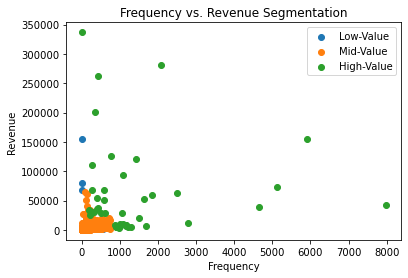

In [129]:
# Low-Value
plt.scatter(x=user_df.query("Segment == 'Low-Value'")['Frequency'],
           y=user_df.query("Segment == 'Low-Value'")['Revenue'], label='Low-Value')

# Mid-Value
plt.scatter(x=user_df.query("Segment == 'Mid-Value'")['Frequency'],
           y=user_df.query("Segment == 'Mid-Value'")['Revenue'], label='Mid-Value')

# High-Value
plt.scatter(x=user_df.query("Segment == 'High-Value'")['Frequency'],
           y=user_df.query("Segment == 'High-Value'")['Revenue'], label='High-Value')

plt.legend(loc='upper right')
plt.title('Frequency vs. Revenue Segmentation')
plt.xlabel('Frequency')
plt.ylabel('Revenue');

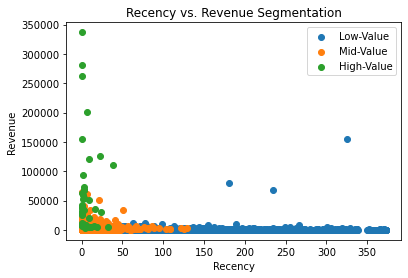

In [130]:
# Low-Value
plt.scatter(x=user_df.query("Segment == 'Low-Value'")['Recency'],
           y=user_df.query("Segment == 'Low-Value'")['Revenue'], label='Low-Value')

# Mid-Value
plt.scatter(x=user_df.query("Segment == 'Mid-Value'")['Recency'],
           y=user_df.query("Segment == 'Mid-Value'")['Revenue'], label='Mid-Value')

# High-Value
plt.scatter(x=user_df.query("Segment == 'High-Value'")['Recency'],
           y=user_df.query("Segment == 'High-Value'")['Revenue'], label='High-Value')

plt.legend(loc='upper right')
plt.title('Recency vs. Revenue Segmentation')
plt.xlabel('Recency')
plt.ylabel('Revenue');

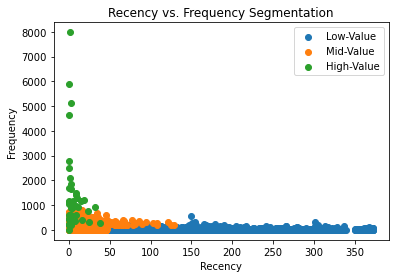

In [131]:
# Low-Value
plt.scatter(x=user_df.query("Segment == 'Low-Value'")['Recency'],
           y=user_df.query("Segment == 'Low-Value'")['Frequency'], label='Low-Value')

# Mid-Value
plt.scatter(x=user_df.query("Segment == 'Mid-Value'")['Recency'],
           y=user_df.query("Segment == 'Mid-Value'")['Frequency'], label='Mid-Value')

# High-Value
plt.scatter(x=user_df.query("Segment == 'High-Value'")['Recency'],
           y=user_df.query("Segment == 'High-Value'")['Frequency'], label='High-Value')

plt.legend(loc='upper right')
plt.title('Recency vs. Frequency Segmentation')
plt.xlabel('Recency')
plt.ylabel('Frequency');

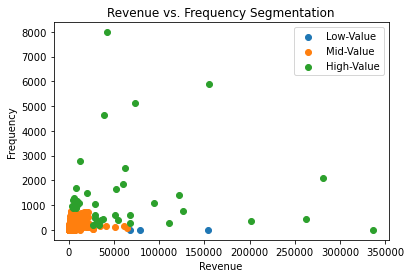

In [132]:
# Low-Value
plt.scatter(x=user_df.query("Segment == 'Low-Value'")['Revenue'],
           y=user_df.query("Segment == 'Low-Value'")['Frequency'], label='Low-Value')

# Mid-Value
plt.scatter(x=user_df.query("Segment == 'Mid-Value'")['Revenue'],
           y=user_df.query("Segment == 'Mid-Value'")['Frequency'], label='Mid-Value')

# High-Value
plt.scatter(x=user_df.query("Segment == 'High-Value'")['Revenue'],
           y=user_df.query("Segment == 'High-Value'")['Frequency'], label='High-Value')

plt.legend(loc='upper right')
plt.title('Revenue vs. Frequency Segmentation')
plt.xlabel('Revenue')
plt.ylabel('Frequency');